In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scopus_handler import ScopusHandler
%matplotlib inline

In [2]:
def preprocess_authors(df):
    _column_name = "Author(s) ID"
    df = df.astype({_column_name: str})
    # nan, "[No author id available]"
    df = df[df[_column_name].notna()]
    df = df[df[_column_name] != "[No author id available]"]
    # Split by ;
    df = __get_num_authors(df)
    df = __get_first_author(df)
    df = __get_last_author(df)
    return df

def __get_num_authors(df):
    df["num_authors"] = df["Author(s) ID"].apply(lambda _text: len(_text.split(";")))
    return df

def __get_first_author(df):
    df["first_author"] = df["Author(s) ID"].apply(lambda _text: _text.split(";")[0])
    return df
    
def __get_last_author(df):
    df["last_author"] = df["Author(s) ID"].apply(lambda _text: _text.split(";")[-1])
    return df

def preprocess_affiliations(df):
    _column_name = "Affiliations"
    df = df.astype({_column_name: str})
    # nan
    df = df[df[_column_name].notna()]
    # Split by ;
    df["num_affiliations"] = df[_column_name].apply(lambda _text: len(_text.split(";")))
    return df

def preprocess_funding(df):
    import math
    _column_name = "Funding Details"
    df["is_funded"] = df[_column_name].fillna(False)
    df["is_funded"] = df["is_funded"].apply(lambda _text: True if _text != False else _text)
#     df["is_funded"] = df[_column_name].apply(lambda _text: False if math.isnan(_text) else True)
    return df

def preprocess_access_type(df):
    _column_name = "Access Type"
    df["is_open"] = df[_column_name].fillna(False)
    df["is_open"] = df["is_open"].apply(lambda _text: True if _text != False else _text)
#     df["is_funded"] = df[_column_name].apply(lambda _text: False if math.isnan(_text) else True)
    return df

def preprocess_df(df):
    # 저자 수, 기관 수: 같은 수
    # 국제 집필 여부, 펀드 유무, 공개 논문 여부: 같은 여부
    # 동일 저널, 동일 문서 타입, 동일 토픽: 같은 분류
    df = df.drop_duplicates(subset=["DOI"])
    df = preprocess_authors(df)
    df = preprocess_affiliations(df)
    df = preprocess_funding(df)
    df = preprocess_access_type(df)
    return df

In [7]:
def get_filtering(df, list_comparisons):
    _filtering = pd.concat(
        list(map(lambda _column_name: df[_column_name] == _target_scopus[_column_name], list_comparisons)),
        axis=1
    ).all(axis=1)
    return _filtering

_m = 3  # 1:m matching
_list_comparisons = [
    # "num_authors",
    # "num_affiliations",
    "first_author",
    "last_author",
    "is_funded",
    "is_open",
    "Source title",
    "Document Type",
]
_list_counterparts = list()

df3 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_2014_comp.csv")
df3_sources = pd.read_csv("scopus/source_2013_comp.csv", header=0)
scopus_2014_comp = ScopusHandler(df3, df3_sources, "scopus_videos_2014_comp", verbose=False)

_set_dois = set(map(lambda _tup_video: _tup_video[2], scopus_2014_comp.set_target_videos().list_target_videos))
# _set_dois = set(map(lambda _tup_video: _tup_video[2], scopus_2014_comp.set_target_videos(where=("content", ("paper_explanation", "paper_assessment", "paper_application"), "in")).list_target_videos))

df3 = preprocess_df(df3)
# Exclude target DOIs
df_target_dois = df3[df3["DOI"].isin(_set_dois)]
df_counterparts = df3[~df3["DOI"].isin(_set_dois)]

for _i, (_idx, _target_scopus) in enumerate(df_target_dois.iterrows()):
    print("[+]Processing %d of %d..." % (_i + 1, len(df_target_dois)))
#     print(_target_scopus)
#     _filtering = pd.concat([
#         df3["num_authors"] == _target_scopus["num_authors"],
#         df3["num_affiliations"] == _target_scopus["num_affiliations"],
#         df3["is_funded"] == _target_scopus["is_funded"],
#         df3["is_open"] == _target_scopus["is_open"],
#         df3["Source title"] == _target_scopus["Source title"],
#         df3["Document Type"] == _target_scopus["Document Type"],
#     ], axis=1).all(axis=1)
    _filtering = get_filtering(df3, _list_comparisons)
    # Randomly sample m matchers
    try:
        _scopus_counterparts = df3.loc[df3[_filtering].sample(_m).index]
    except ValueError:  # sample larger than population
        print("\t[-]Sample larger than population\n\tDOI: %s\tPopulation: %d" % (_target_scopus["DOI"], len(df3[_filtering])))
        # _scopus_counterparts = df3[_filtering]
    else:
        # Append to list
        _list_counterparts.append((_target_scopus, _scopus_counterparts))
        # Drop samples from original df
        df3 = df3.drop(_scopus_counterparts.index)

[+]Duplicates have been dropped from df_scopus.	Before: 9598	After: 9336
# Total DOIs: 9336	# DOIs w/ videos: 102	Ratio: 0.011
# Total videos: 143	# Target videos: 143	Ratio: 1.000
# Total subjects: 43	# subjects w/ videos: 24	Ratio: 0.558
# Total journals: 133	# journals w/ videos: 35	Ratio: 0.263
[+]Processing 1 of 102...
[+]Processing 2 of 102...
[+]Processing 3 of 102...
	[-]Sample larger than population
	DOI: 10.1016/j.plrev.2013.08.002	Population: 1
[+]Processing 4 of 102...
[+]Processing 5 of 102...
[+]Processing 6 of 102...
	[-]Sample larger than population
	DOI: 10.1016/j.patcog.2013.08.011	Population: 1
[+]Processing 7 of 102...
[+]Processing 8 of 102...
[+]Processing 9 of 102...
[+]Processing 10 of 102...
	[-]Sample larger than population
	DOI: 10.1016/j.plrev.2013.11.003	Population: 1
[+]Processing 11 of 102...
[+]Processing 12 of 102...
[+]Processing 13 of 102...
[+]Processing 14 of 102...
[+]Processing 15 of 102...
[+]Processing 16 of 102...
[+]Processing 17 of 102...
[+]

/home/hweem/git/s-transformers/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/hweem/git/s-transformers/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


{'whiskers': [<matplotlib.lines.Line2D at 0x7fea7b7c5890>,
 'caps': [<matplotlib.lines.Line2D at 0x7fea7b7c5ed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fea7b7c5450>,
 'medians': [<matplotlib.lines.Line2D at 0x7fea7b7cd7d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fea7b7cdc10>,
 'means': []}

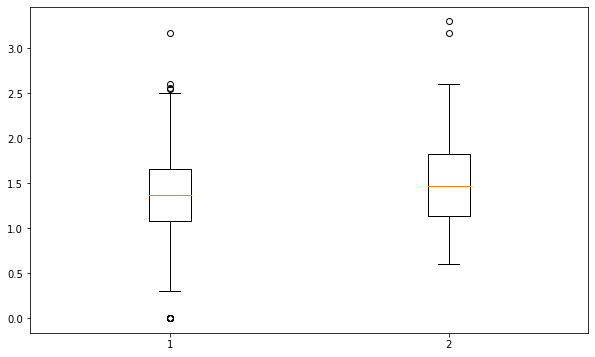

In [9]:
import functools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

_metric = "Cited by"
_metrics_targets = list(map(lambda _twin: _twin[0][_metric], _list_counterparts))
_metrics_counterparts = functools.reduce(lambda a, b: a + b, list(map(lambda _twin: list(_twin[1][_metric].values), _list_counterparts)))
plt.figure(figsize=(10, 6))
plt.boxplot([
    np.log10(np.nan_to_num(_metrics_counterparts)),
    np.log10(np.nan_to_num(_metrics_targets)),
#     np.nan_to_num(_metrics_counterparts),
#     np.nan_to_num(_metrics_targets),
])


In [10]:
from scipy import stats
_s2014, _p2014 = stats.ttest_ind(
    np.log10(_metrics_counterparts)[~np.isnan(np.log10(_metrics_counterparts))],
    np.log10(_metrics_targets)[~np.isnan(np.log10(_metrics_targets))]
)
print("2014\tS = %f\tp = %f"%(_s2014, _p2014))

2014	S = -2.900526	p = 0.003966


In [11]:
len(np.log10(_metrics_counterparts)[~np.isnan(np.log10(_metrics_counterparts))]), len(np.log10(_metrics_targets)[~np.isnan(np.log10(_metrics_targets))])

(260, 85)

[+]Duplicates have been dropped from df_scopus.	Before: 9598	After: 9336
# Total DOIs: 9336	# DOIs w/ videos: 13	Ratio: 0.001
# Total videos: 16	# Target videos: 16	Ratio: 1.000
# Total subjects: 43	# subjects w/ videos: 9	Ratio: 0.209
# Total journals: 133	# journals w/ videos: 10	Ratio: 0.075
[+]Processing 1 of 13...
	[-]Sample larger than population
	DOI: 10.1016/j.patcog.2013.08.011	Population: 1
[+]Processing 2 of 13...
[+]Processing 3 of 13...
[+]Processing 4 of 13...
[+]Processing 5 of 13...
[+]Processing 6 of 13...
[+]Processing 7 of 13...
	[-]Sample larger than population
	DOI: 10.1021/ct4010307	Population: 2
[+]Processing 8 of 13...
[+]Processing 9 of 13...
[+]Processing 10 of 13...
	[-]Sample larger than population
	DOI: 10.1371/journal.pcbi.1003496	Population: 2
[+]Processing 11 of 13...
[+]Processing 12 of 13...
[+]Processing 13 of 13...
2014	S = -3.676817	p = 0.000727


(30, 10)

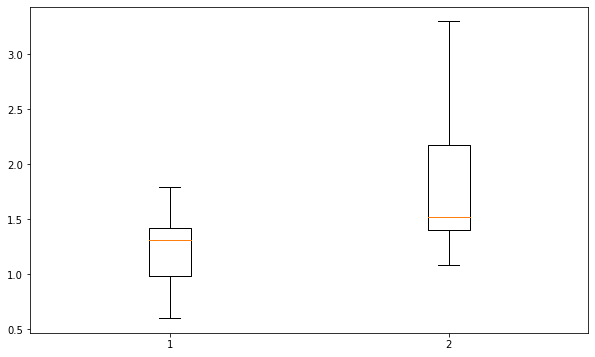

In [15]:
def get_filtering(df, list_comparisons):
    _filtering = pd.concat(
        list(map(lambda _column_name: df[_column_name] == _target_scopus[_column_name], list_comparisons)),
        axis=1
    ).all(axis=1)
    return _filtering

_m = 3  # 1:m matching
_list_comparisons = [
#     "num_authors",
    "num_affiliations",
    "is_funded",
    "is_open",
    "Source title",
    "Document Type",
]
_list_counterparts = list()

df3 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_2014_comp.csv")
df3_sources = pd.read_csv("scopus/source_2013_comp.csv", header=0)
scopus_2014_comp = ScopusHandler(df3, df3_sources, "scopus_videos_2014_comp", verbose=False)

# _set_dois = set(map(lambda _tup_video: _tup_video[2], scopus_2014_comp.set_target_videos().list_target_videos))
_set_dois = set(map(lambda _tup_video: _tup_video[2], scopus_2014_comp.set_target_videos(where=("content", ("paper_explanation", "paper_assessment", "paper_application"), "in")).list_target_videos))

df3 = preprocess_df(df3)
# Exclude target DOIs
df_target_dois = df3[df3["DOI"].isin(_set_dois)]
df_counterparts = df3[~df3["DOI"].isin(_set_dois)]

for _i, (_idx, _target_scopus) in enumerate(df_target_dois.iterrows()):
    print("[+]Processing %d of %d..." % (_i + 1, len(df_target_dois)))
#     print(_target_scopus)
#     _filtering = pd.concat([
#         df3["num_authors"] == _target_scopus["num_authors"],
#         df3["num_affiliations"] == _target_scopus["num_affiliations"],
#         df3["is_funded"] == _target_scopus["is_funded"],
#         df3["is_open"] == _target_scopus["is_open"],
#         df3["Source title"] == _target_scopus["Source title"],
#         df3["Document Type"] == _target_scopus["Document Type"],
#     ], axis=1).all(axis=1)
    _filtering = get_filtering(df3, _list_comparisons)
    # Randomly sample m matchers
    try:
        _scopus_counterparts = df3.loc[df3[_filtering].sample(_m).index]
    except ValueError:  # sample larger than population
        print("\t[-]Sample larger than population\n\tDOI: %s\tPopulation: %d" % (_target_scopus["DOI"], len(df3[_filtering])))
        # _scopus_counterparts = df3[_filtering]
    else:
        # Append to list
        _list_counterparts.append((_target_scopus, _scopus_counterparts))
        # Drop samples from original df
        df3 = df3.drop(_scopus_counterparts.index)

import functools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

_metric = "Cited by"
_metrics_targets = list(map(lambda _twin: _twin[0][_metric], _list_counterparts))
_metrics_counterparts = functools.reduce(lambda a, b: a + b, list(map(lambda _twin: list(_twin[1][_metric].values), _list_counterparts)))
plt.figure(figsize=(10, 6))
plt.boxplot([
    np.log10(np.nan_to_num(_metrics_counterparts)),
    np.log10(np.nan_to_num(_metrics_targets)),
#     np.nan_to_num(_metrics_counterparts),
#     np.nan_to_num(_metrics_targets),
])

from scipy import stats
_s2014, _p2014 = stats.ttest_ind(
    np.log10(_metrics_counterparts)[~np.isnan(np.log10(_metrics_counterparts))],
    np.log10(_metrics_targets)[~np.isnan(np.log10(_metrics_targets))]
)
print("2014\tS = %f\tp = %f"%(_s2014, _p2014))
len(np.log10(_metrics_counterparts)[~np.isnan(np.log10(_metrics_counterparts))]), len(np.log10(_metrics_targets)[~np.isnan(np.log10(_metrics_targets))])

In [ ]:
_2019_wo_videos_cit = np.log10(df1[~df1.DOI.isin(_idx_papers_2019)]["Cited by"].dropna().astype(int))
_2019_w_videos_cit = np.log10(df1[df1.DOI.isin(_idx_papers_2019)]["Cited by"].dropna().astype(int))
_2017_wo_videos_cit = np.log10(df2[~df2.DOI.isin(_idx_papers_2017)]["Cited by"].dropna().astype(int))
_2017_w_videos_cit = np.log10(df2[df2.DOI.isin(_idx_papers_2017)]["Cited by"].dropna().astype(int))
_2014_wo_videos_cit = np.log10(df3[~df3.DOI.isin(_idx_papers_2014)]["Cited by"].dropna().astype(int))
_2014_w_videos_cit = np.log10(df3[df3.DOI.isin(_idx_papers_2014)]["Cited by"].dropna().astype(int))

plt.figure(figsize=(10, 6))
plt.title("Citation")
# plt.yscale("log")
# plt.ylim([0, 200])
plt.ylabel("log10(Citation)")
plt.boxplot([
    _2019_wo_videos_cit,
    _2019_w_videos_cit,
    _2017_wo_videos_cit,
    _2017_w_videos_cit,
    _2014_wo_videos_cit,
    _2014_w_videos_cit
],
    labels=[
        "2019 w/o videos\n(N=%s)"%len(_2019_wo_videos_cit),
        "2019 w/ videos\n(N=%s)"%len(_2019_w_videos_cit),
        "2017 w/o videos\n(N=%s)"%len(_2017_wo_videos_cit),
        "2017 w/ videos\n(N=%s)"%len(_2017_w_videos_cit),
        "2014 w/o videos\n(N=%s)"%len(_2014_wo_videos_cit),
        "2014 w/ videos\n(N=%s)"%len(_2014_w_videos_cit)
    ]
)